In [1]:
import torch
import os
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import AdamW, lr_scheduler
import pytorch_lightning as pl
from torchvision import models
import torch_pruning as tp
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import networkx as nx
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter, RandomCrop
from sklearn.metrics import accuracy_score, f1_score
import torchmetrics.functional as tmf
import copy

In [2]:
def get_device():
    return torch.device("mps" if torch.backends.mps.is_available() else 
                        "cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class AlexNetFineTuner(pl.LightningModule):
    def __init__(self, learning_rate=1e-4, num_classes=10):
        super(AlexNetFineTuner, self).__init__()
        self.save_hyperparameters()

        # Load pre-trained AlexNet
        self.model = models.alexnet(pretrained=False)
        self.model.classifier[6] = torch.nn.Linear(4096, num_classes)  # Update the classifier layer

        # Removed self.metrics dictionary to avoid confusion

        self.test_outputs = []

    def forward(self, x):
        return self.model(x)

    def print_dependency_graph(self, DG):
        print("\nDependency Graph Details:")
        for module, node in DG.module2node.items():
            print(f"Module: {module}")
            for dep in node.dependencies:
                print(f"    * Target Module: {dep.target.module}")

    def visualize_dependency_graph(self, DG):
        """Visualize the dependency graph using networkx."""
        G = nx.DiGraph()
        for module, node in DG.module2node.items():
            for dep in node.dependencies:
                G.add_edge(str(module), str(dep.target.module))
        plt.figure(figsize=(12, 8))
        nx.draw(G, with_labels=True, node_size=1000, font_size=8, node_color="skyblue", edge_color="gray")
        plt.title("Dependency Graph")
        plt.show()

    def prune_model(self, pruning_percentage=0.2, train_loader=None, val_loader=None, fine_tune_epochs=1, fine_tune_lr=1e-5):
        # Prepare example inputs for building the dependency graph
        self.custom_device = get_device()
        example_inputs = torch.randn(1, 3, 224, 224, dtype=torch.float32, device=self.custom_device)

        self.model = self.model.to(self.custom_device)

        print("MODEL BEFORE PRUNING:\n", self.model)

        # Build the Dependency Graph
        DG = tp.DependencyGraph().build_dependency(self.model, example_inputs)

        # Layers to prune
        layers_to_prune = {
            "conv2": self.model.features[3],    # second conv layer in AlexNet
            "conv3": self.model.features[6],
            "conv4": self.model.features[8],
            "conv5": self.model.features[10],
            "fc1": self.model.classifier[1],
            "fc2": self.model.classifier[4]
        }

        def get_pruning_indices(module, percentage):
            with torch.no_grad():
                weight = module.weight.data
                if isinstance(module, torch.nn.Conv2d):
                    channel_norms = weight.abs().mean(dim=[1,2,3])  # shape: [out_channels]
                elif isinstance(module, torch.nn.Linear):
                    channel_norms = weight.abs().mean(dim=1)         # shape: [out_features]
                else:
                    return None

                pruning_count = int(channel_norms.size(0) * percentage)
                if pruning_count == 0:
                    return []

                _, prune_indices = torch.topk(channel_norms, pruning_count, largest=False)
                return prune_indices.tolist()

        groups = []
        for layer_name, layer_module in layers_to_prune.items():
            if isinstance(layer_module, torch.nn.Conv2d):
                prune_fn = tp.prune_conv_out_channels
            elif isinstance(layer_module, torch.nn.Linear):
                prune_fn = tp.prune_linear_out_channels
            else:
                print(f"Skipping {layer_name}: Unsupported layer type {type(layer_module)}")
                continue

            pruning_idxs = get_pruning_indices(layer_module, pruning_percentage)
            if pruning_idxs is None or len(pruning_idxs) == 0:
                print(f"No channels to prune for {layer_name}.")
                continue

            group = DG.get_pruning_group(layer_module, prune_fn, idxs=pruning_idxs)
            if DG.check_pruning_group(group):
                groups.append((layer_name, group))
            else:
                print(f"Invalid pruning group for layer {layer_name}, skipping pruning.")

        if groups:
            print(f"Pruning with {pruning_percentage*100}% percentage on {len(groups)} layers...")
            for layer_name, group in groups:
                print(f"Pruning layer: {layer_name}")
                group.prune()

            print("MODEL AFTER PRUNING:\n", self.model)
        else:
            print("No valid pruning groups found. The model was not pruned.")
            return

        # Optional fine-tuning after pruning
        if train_loader is not None and val_loader is not None:
            print("Starting fine-tuning of the pruned model...")
            self.fine_tune_model(self.model, train_loader, val_loader, fine_tune_epochs, fine_tune_lr)
        else:
            print("No train/val loaders provided for fine-tuning.")

    def training_step(self, batch, batch_idx):
        images, labels = batch
        images, labels = images.to(self.custom_device), labels.to(self.custom_device)

        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        images, labels = images.to(self.custom_device), labels.to(self.custom_device)

        outputs = self(images)
        val_loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        val_acc = (preds == labels).float().mean()
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", val_acc, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        images, labels = images.to(self.custom_device), labels.to(self.custom_device)

        outputs = self(images)
        test_loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        test_acc = (preds == labels).float().mean()

        print(f"Test Step: Batch {batch_idx}, Loss: {test_loss.item()}, Acc: {test_acc.item()}")
        self.test_outputs.append({"test_loss": test_loss.item(), "test_acc": test_acc.item()})

        self.log("test_loss_batch", test_loss, prog_bar=True)
        self.log("test_acc_batch", test_acc, prog_bar=True)

        return test_loss

    def on_test_epoch_end(self):
        # We'll rely on evaluation outside the model rather than storing inside self.metrics
        avg_loss = sum(o["test_loss"] for o in self.test_outputs) / len(self.test_outputs)
        avg_acc = sum(o["test_acc"] for o in self.test_outputs) / len(self.test_outputs)
        print(f"Test Epoch End: Avg Loss: {avg_loss}, Avg Acc: {avg_acc}")
        self.log("test_loss_epoch", avg_loss, prog_bar=True)
        self.log("test_acc_epoch", avg_acc, prog_bar=True)
        self.test_outputs = []

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}
    
    def fine_tune_model(self, model, train_loader, val_loader, epochs=1, learning_rate=1e-5):           # TODO: CHANGE EPOCH BACK TO 3
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        loss_fn = torch.nn.CrossEntropyLoss()

        for epoch in range(epochs):
            model.train()
            train_loss, train_correct = 0, 0
            for images, labels in train_loader:
                images, labels = images.to(self.custom_device), labels.to(self.custom_device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_correct += (outputs.argmax(dim=1) == labels).sum().item()

            model.eval()
            val_loss, val_correct = 0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(self.custom_device), labels.to(self.custom_device)

                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    val_correct += (outputs.argmax(dim=1) == labels).sum().item()

            train_acc = train_correct / len(train_loader.dataset)
            val_acc = val_correct / len(val_loader.dataset)

            print(f"Epoch {epoch + 1}/{epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

In [4]:
def evaluate_model(model, dataloader):
    """
    Evaluates the model on the given dataloader and returns accuracy and F1 score.
    """
    all_preds = []
    all_labels = []
    device = get_device()
    model = model.to(device).to(torch.float32)

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return accuracy, f1

In [5]:
def plot_metrics(metrics):
    print("Metrics Debug:")
    print("Pruning Percentages:", metrics["pruning_percentage"])
    print("Test Accuracy:", metrics["test_accuracy"])
    print("F1 Score:", metrics["f1_score"])
    print("Model Size:", metrics["model_size"])

    plt.figure()
    plt.plot(metrics["pruning_percentage"], metrics["test_accuracy"], marker='o', label="Accuracy")
    plt.title("Test Accuracy vs. Pruning Percentage")
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    # If you want to also visualize loss or other metrics, adjust accordingly
    plt.figure()
    plt.plot(metrics["pruning_percentage"], metrics["f1_score"], marker='o', color="red", label="F1 Score")
    plt.title("F1 Score vs. Pruning Percentage")
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(metrics["pruning_percentage"], metrics["model_size"], marker='o', color="green", label="Model Size")
    plt.title("Model Size vs. Pruning Percentage")
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("Number of Parameters")
    plt.grid(True)
    plt.legend()
    plt.show()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: p-mangal (p-mangal-university-of-amsterdam). Use `wandb login --relogin` to force relogin


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Applying 50.0% pruning...
Original Accuracy: 0.8985, Original F1 Score: 0.8983
MODEL BEFORE PRUNING:
 AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Test Step: Batch 0, Loss: 0.6242039203643799, Acc: 0.71875
Test Step: Batch 1, Loss: 0.9360430836677551, Acc: 0.71875
Test Step: Batch 2, Loss: 0.6151455640792847, Acc: 0.75
Test Step: Batch 3, Loss: 0.673105001449585, Acc: 0.75
Test Step: Batch 4, Loss: 0.7803996801376343, Acc: 0.71875
Test Step: Batch 5, Loss: 0.627574622631073, Acc: 0.8125
Test Step: Batch 6, Loss: 0.7016297578811646, Acc: 0.75
Test Step: Batch 7, Loss: 0.7063338160514832, Acc: 0.78125
Test Step: Batch 8, Loss: 0.7157211303710938, Acc: 0.6875
Test Step: Batch 9, Loss: 0.5291578769683838, Acc: 0.78125
Test Step: Batch 10, Loss: 0.6091296672821045, Acc: 0.71875
Test Step: Batch 11, Loss: 0.7446481585502625, Acc: 0.75
Test Step: Batch 12, Loss: 0.5439218282699585, Acc: 0.84375
Test Step: Batch 13, Loss: 0.9906346201896667, Acc: 0.65625
Test Step: Batch 14, Loss: 0.8535792231559753, Acc: 0.6875
Test Step: Batch 15, Loss: 0.404593288898468, Acc: 0.90625
Test Step: Batch 16, Loss: 0.5799719095230103, Acc: 0.8125
Test Step

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.7531999945640564     │
│      test_acc_epoch       │    0.7530950307846069     │
│      test_loss_batch      │    0.7115582227706909     │
│      test_loss_epoch      │    0.7116789221763611     │
└───────────────────────────┴───────────────────────────┘

Pruned Accuracy: 0.7532, Pruned F1 Score: 0.7523
All Metrics-----------> {'pruning_percentage': [50.0], 'test_accuracy': [0.7532], 'f1_score': [0.7522766286161234], 'model_size': [14368042]}
Pruned model saved to: ./pruned_models/alexnet_pruned_50.pth
Metrics Debug:
Pruning Percentages: [50.0]
Test Accuracy: [0.7532]
F1 Score: [0.7522766286161234]
Model Size: [14368042]


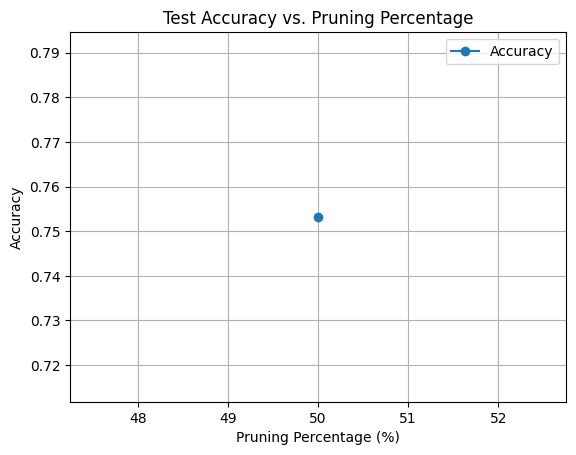

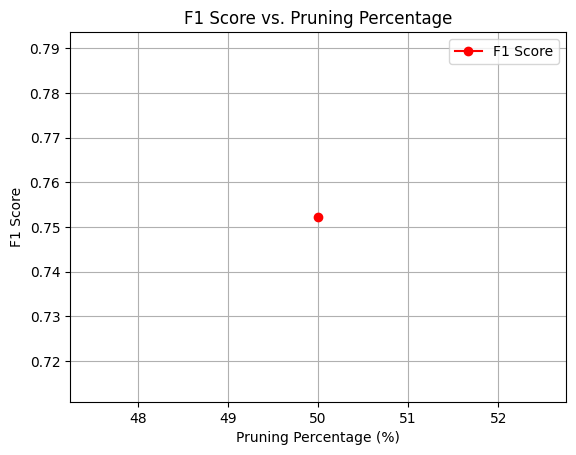

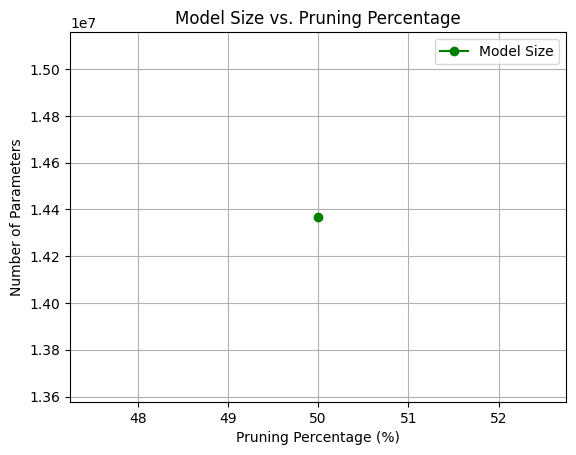

epoch,▁
test_acc_batch,▁
test_acc_epoch,▁
test_loss_batch,▁
test_loss_epoch,▁
trainer/global_step,▁
epoch,0
test_acc_batch,0.7532
test_acc_epoch,0.7531
test_loss_batch,0.71156
test_loss_epoch,0.71168


In [6]:
def main():
    wandb.init(project='alexnet_depGraph', name='AlexNet_Run')
    wandb_logger = WandbLogger(log_model=False)

    device = get_device()
    checkpoint_path = "../checkpointsAlex/checkpoint_with_aug_epoch5.ckpt"
    model = AlexNetFineTuner.load_from_checkpoint(checkpoint_path).to(device)

    # Only one metrics dictionary is used here in main
    metrics = {
        "pruning_percentage": [],
        "test_accuracy": [],
        "f1_score": [],
        "model_size": []
    }
    
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    full_train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_size = int(0.8 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32)
    test_dataloader = DataLoader(test_dataset, batch_size=32)

    pruning_percentages = [0.5]

    os.makedirs('./pruned_models/', exist_ok=True)
    trainer = pl.Trainer(max_epochs=1, logger=wandb_logger, accelerator=device.type)            # TODO: CHANGE EPOCH BACK TO 5

    for pruning_percentage in pruning_percentages:
        print(f"Applying {pruning_percentage * 100}% pruning...")
        model_to_be_pruned = copy.deepcopy(model)  

        # Evaluate before pruning
        orig_accuracy, orig_f1 = evaluate_model(model_to_be_pruned, test_dataloader)
        print(f"Original Accuracy: {orig_accuracy:.4f}, Original F1 Score: {orig_f1:.4f}")

        # Prune and fine-tune
        model_to_be_pruned.prune_model(pruning_percentage=pruning_percentage, 
                                       train_loader=train_dataloader, 
                                       val_loader=val_dataloader, 
                                       fine_tune_epochs=1, 
                                       fine_tune_lr=1e-5)                       # TODO: CHANGE EPOCH BACK TO 5           
        model_to_be_pruned.to(device)

        # Test the pruned model
        trainer.test(model_to_be_pruned, dataloaders=test_dataloader)

        pruned_accuracy, pruned_f1 = evaluate_model(model_to_be_pruned, test_dataloader)
        print(f"Pruned Accuracy: {pruned_accuracy:.4f}, Pruned F1 Score: {pruned_f1:.4f}")

        # Update metrics
        metrics["pruning_percentage"].append(pruning_percentage * 100)
        metrics["test_accuracy"].append(pruned_accuracy)
        metrics["f1_score"].append(pruned_f1)
        metrics["model_size"].append(
            sum(p.numel() for p in model_to_be_pruned.parameters() if p.requires_grad)
        )

        print("All Metrics----------->", metrics)
        
        model_to_be_pruned.zero_grad()
        model_to_be_pruned.to("cpu")
        pruned_model_path = f"./pruned_models/alexnet_pruned_{int(pruning_percentage * 100)}.pth"
        torch.save(model_to_be_pruned.state_dict(), pruned_model_path)

        print(f"Pruned model saved to: {pruned_model_path}")

    # Plot metrics after all pruning iterations
    plot_metrics(metrics)
    wandb.finish()

if __name__ == "__main__":
    main()

In [7]:
import os
import torch

def list_pruned_models(directory='./pruned_models/'):
    # List all files in the directory
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.pth')]

pruned_models = list_pruned_models()
print("Available Pruned Models:", pruned_models)


Available Pruned Models: ['./pruned_models/alexnet_pruned_10.pth', './pruned_models/alexnet_pruned_0.pth', './pruned_models/alexnet_pruned_50.pth', './pruned_models/alexnet_pruned_20.pth', './pruned_models/alexnet_pruned_30.pth']


In [8]:
def load_pruned_model(model_path):
    print(f"Loading pruned model from: {model_path}")
    model = torch.load(model_path)
    model = model.to("mps").to(torch.float32)  # Move to MPS if needed
    return model

# Example: Load a pruned model with 30% pruning
pruned_model_path = "./pruned_models/alexnet_pruned_10.pth"
pruned_model = load_pruned_model(pruned_model_path)

# Verify the loaded model
print(pruned_model)


Loading pruned model from: ./pruned_models/alexnet_pruned_10.pth
AlexNetFineTuner(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 173, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(173, 346, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(346, 231, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(231, 231, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (c

/var/folders/wc/wpc2_w2s73z_8qr0dbq576x00000gn/T/ipykernel_13826/3219533670.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
